#**ATP Match Data Clean and Database Creation**

Using what we learned from exploring the data, we'll now create an analysis SQL database that removes some of the troubling observations, repopulates some missing data, and some other pre-processing. First, we mount my google drive where I've saved the data we'll be using. 

In [325]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/ATP Tennis/Data/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We then import the packages we'll need. 


In [389]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import os
import glob
import seaborn as sns
import datetime
import re

Then we read in the csv data into pandas data frames. We'll use these to clean the data before creating our analysis database. The data are 1991-2020 ATP tour-level main draw singles matches, players, and rankings. Most of the information in the player and ranking tables is already be in the match data, but we'll see if the player and ranking tables allow us to populate any missing information.

**Player Data**

We read in the player data. We don't do any processing of this data.

In [ ]:
atp_players = pd.read_csv("atp_players.csv",names=["player","first_name","last_name","hand","birth_date","country_code"])

**Ranking Data**

We add year, month, and day fields to the ranking data. We also standardize some column names. Finally, we drop duplicates. Looking at the duplicates, we see that they are exact duplicates and so no information is lost by "deduping". 

In [314]:
filenames = [i for i in glob.glob('*.{}'.format('csv')) if "atp_rankings" in i]
atp_rankings = pd.concat([pd.read_csv(f) for f in filenames if f !="atp_rankings_current.csv"])
atp_rankings_current = pd.read_csv("atp_rankings_current.csv",names=atp_rankings.columns)
atp_rankings = pd.concat([atp_rankings,atp_rankings_current])
atp_rankings["year"] = [int(np.floor(i/10000)) for i in atp_rankings["ranking_date"].values]
atp_rankings['monthday'] = atp_rankings['ranking_date'] - atp_rankings['year']*10000
atp_rankings['month'] = [int(np.floor(i/100)) for i in atp_rankings['monthday']]
atp_rankings['day'] = atp_rankings['monthday'] - atp_rankings['month']*100
del atp_rankings['monthday']
atp_rankings = atp_rankings.drop_duplicates()

**Match Data**

After reading in the match data, we add a year field to the to keep track of the file source as well as the year.

In [584]:
filenames = [i for i in glob.glob('*.{}'.format('csv')) if "atp_matches" in i]
atp_matches = pd.concat([pd.read_csv(f) for f in filenames ])
atp_matches["year"] = [int(i[0:4]) for i in atp_matches["tourney_id"].values]

We identified a series of ways in which we might want to clean up the match data in the data exploration notebook. These include the following bullets. See that notebook for more detail on these. 

- Drop matches with no detail match statistics
- Drop Davis Cup matches
- Drop 2020
- Drop matches with missing minutes
- Drop matches with missing ranking points and rankings
- Create set scores from `score` field

Let's actually work through some of that cleaning now. 

First, we drop matches with missing detail match statistics. This can be done by just filtering based on one of the detail match statistics. We'll use winner ace count (`w_ace`). We also remove all Davis Cup matches useing the `tourney_level` field. We then drop the 2020 season, since the data are incomplete. Finally, we drop matches with missing `minutes`  (most of these are from 2015 and before 2000). There must be something a bit off about these matches. So it's probably safest to not rely on any data from them. For now, we also drop matches with missing player ranks or points. These are primarily from before 2000. 

In [585]:
atp_matches = atp_matches[atp_matches["w_ace"].notnull()]
atp_matches = atp_matches[atp_matches["tourney_level"] != "D"]
atp_matches = atp_matches[atp_matches["year"] != 2020]
atp_matches = atp_matches[atp_matches["minutes"].notnull()]
atp_matches = atp_matches[atp_matches["winner_rank"].notnull()]
atp_matches = atp_matches[atp_matches["loser_rank"].notnull()]
atp_matches = atp_matches[atp_matches["winner_rank_points"].notnull()]
atp_matches = atp_matches[atp_matches["loser_rank_points"].notnull()]

We're still left with over 80,000 matches.

In [586]:
atp_matches.shape

(80683, 50)

Now, let's create set by set scores from the `score` field. We'll also identify when a player retired, drop matches with suspicious or obviously wrong scores, and add a field indicating whether there was a tiebreak and what the score was. 

First we create a retirement indicator. We see that ~2,000 matches ended in retirement (i.e., about 2.8%).

In [587]:
atp_matches["retirement"] = [1 if str(i).find("RET") != -1 else 0 for i in atp_matches["score"]]
x = Counter(atp_matches["retirement"])
print("Number of Matches Ending in Retirement:",x[1])
print("Percent of Matches Ending in Retirement:",round(x[1]/x[0]*100,1),"%")

Number of Matches Ending in Retirement: 2191
Percent of Matches Ending in Retirement: 2.8 %


Next we drop any matches with a score that includes a letter other than "RET". There are only 22 of these. 

In [588]:
score = [str(s).replace('RET', '').strip() for s in atp_matches["score"]]
any_alpha = [re.search('[a-zA-Z]', str(s)) for s in score]
drop_any_alpha = [s is None for s in any_alpha]
print(Counter(drop_any_alpha))
atp_matches = atp_matches[drop_any_alpha]
atp_matches = atp_matches[atp_matches["score"]!=""]
atp_matches.shape

Counter({True: 80661, False: 22})


(80661, 51)

Note that there is one match that ended before one game was finished. It lasted only 8 minutes.

In [589]:
score = [str(s).replace('RET', '').strip() for s in atp_matches["score"]]
atp_matches[[True if s=="" else False for s in score ]]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,retirement
2012,2007-520,Roland Garros,Clay,128,G,20070528,8,104022,13,NaN,Mikhail Youzhny,R,183.0,RUS,24.922656,103401,NaN,NaN,Jan Hernych,R,190.0,CZE,27.890486,RET,5,R128,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,5.0,3.0,1.0,0.0,1.0,1.0,15.0,1685.0,92.0,454.0,2007,1


Now we break the overall score into set by set scores. Note that this creates many missing values for third, fourth, and fifth sets, which are not always played. We then break the set level scores into the number of games won in that set for each player. Note that the winner of the match's games are listed first. Also note that the results of tie breaks are in parentheses. The tie break score is just the number of points won by the loser of the tie break. We move these into another seperate column. So we end up with three columns per set: winner games, loser games, and tie break score.

In [590]:
set_scores = pd.DataFrame.from_records([str(s).split(" ") for s in score],
                                       columns=["Set1","Set2","Set3","Set4","Set5"])
def getSetScores(n):
  Set_score = pd.DataFrame.from_records([s.replace(')', '').split("(") for s in 
                                         [str(s) for s in set_scores["Set"+str(n)].values]],
                                        columns=["Set"+str(n)+"_Score","Set"+str(n)+"_Tiebreak"])
  Set_Tiebreak = Set_score["Set"+str(n)+"_Tiebreak"]
  Set_score = pd.DataFrame.from_records([s.split("-") for s in Set_score["Set"+str(n)+"_Score"]],
                                        columns=["Winner_Set"+str(n)+"_Score","Loser_Set"+str(n)+"_Score"])
  Set_score["Set"+str(n)+"_Tiebreak"] = Set_Tiebreak
  atp_matches["Winner_Set"+str(n)+"_Score"] = Set_score["Winner_Set"+str(n)+"_Score"]
  atp_matches["Loser_Set"+str(n)+"_Score"] = Set_score["Loser_Set"+str(n)+"_Score"]
  atp_matches["Set"+str(n)+"_Tiebreak"] = Set_score["Set"+str(n)+"_Tiebreak"]

Set1 = getSetScores(1)
Set2 = getSetScores(2)
Set3 = getSetScores(3)
Set4 = getSetScores(4)
Set5 = getSetScores(5)

**Create SQL Database**

We create a `sqlite3` database that will store the match, player, and ranking information. So we establish the database first.


In [591]:
connection = sqlite3.connect('/content/drive/My Drive/ATP Tennis/Database/ATP_Tennis.db')
c = connection.cursor()

And then we create tables in the database. 

In [592]:
atp_matches.to_sql('ATP_MATCHES', connection, if_exists='replace', index = False)
atp_players.to_sql('ATP_PLAYERS', connection, if_exists='replace', index = False)
atp_rankings.to_sql('ATP_RANKINGS', connection, if_exists='replace', index = False)

**Test Database**

Let's run a quick check that things are working properly. We'll query which players were ranked number 1 since 1991 and count how many weeks they held the top spot. Note that the ranking data is at the weekly level.

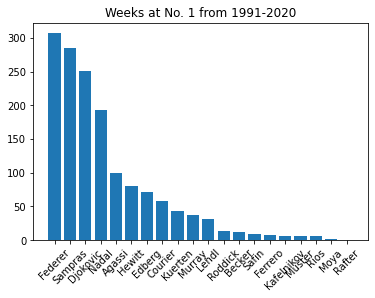

In [593]:
c.execute('''
SELECT b.last_name, count() as weeks_no_1
FROM ATP_RANKINGS as a, ATP_PLAYERS as b
ON a.player=b.player
WHERE a.rank == 1
GROUP BY b.last_name
ORDER BY -weeks_no_1
''')
No1_Ranked_Players = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
plt.bar(No1_Ranked_Players["last_name"], No1_Ranked_Players["weeks_no_1"])
plt.title("Weeks at No. 1 from 1991-2020")
plt.xticks(rotation=45)
plt.show()

What is particularly striking is the level of dominance by particular sets of players. We plot the rank of all players that were ranked number 1 for more than 60 weeks from 1991-2020. This allows us to see the transition from the 90s era of dominance by Sampras, Agassi, and Hewitt to the modern era dominated by Federer, Nadal, and Djokovic. 

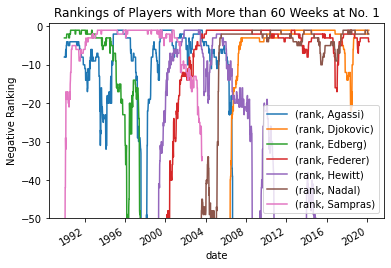

In [594]:
c.execute('''
SELECT a.*, c.last_name
FROM ATP_RANKINGS as a 
INNER JOIN
  (
    SELECT player,count() as weeks_no_1
    FROM ATP_RANKINGS
    WHERE rank==1
    GROUP BY player
    HAVING weeks_no_1>60
  ) as b 
ON a.player=b.player 
INNER JOIN ATP_PLAYERS as c
ON a.player=c.player 
ORDER BY a.ranking_date
''')
No1_Ranked_Players = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
No1_Ranked_Players['rank'] = -No1_Ranked_Players['rank']
No1_Ranked_Players['date'] = [datetime.date(year=i,day=j,month=k) for i,j,k in zip(No1_Ranked_Players['year'],No1_Ranked_Players['day'],No1_Ranked_Players['month'])]
No1_Ranked_Players = No1_Ranked_Players.pivot(index='date',columns='last_name')[['rank']]
No1_Ranked_Players.plot()
plt.ylim(-50,1)
plt.title("Rankings of Players with More than 60 Weeks at No. 1")
plt.ylabel("Negative Ranking")
plt.legend()
plt.show()

So we now have a cleaned analysis database that we can use for quick analyses like those above as well as for more involved modeling and analysis. We'll get into that in future notebooks.